<a href="https://colab.research.google.com/github/hj245668/DL/blob/main/1209_NLP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Reuters Dataset 통합 분류 모델 실험
M1-M13 모델 전체 실험
- M1~M8: 전통적 ML 모델들 (Naive Bayes, LR, SVM, Tree-based, Voting)
- M10~M11: Gradient Boosting (XGBoost, LightGBM)
- M12~M13: Deep Learning (Dense Networks)
"""

import warnings
warnings.filterwarnings('ignore')

# 시스템 및 하드웨어 정보
import platform
import psutil
import subprocess

print("="*80)
print("실험 환경 정보")
print("="*80)
print(f"Python 버전: {platform.python_version()}")
print(f"OS: {platform.system()} {platform.release()}")
print(f"CPU: {platform.processor()}")
print(f"물리 코어: {psutil.cpu_count(logical=False)}, 논리 코어: {psutil.cpu_count(logical=True)}")
print(f"메모리: {psutil.virtual_memory().total / (1024**3):.2f} GB")

# TensorFlow/Keras 관련
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# GPU 설정 확인
print("\n" + "="*80)
print("GPU 설정")
print("="*80)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU 사용 가능: {len(gpus)}개")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
    except RuntimeError as e:
        print(f"GPU 설정 오류: {e}")
else:
    print("⚠ GPU를 찾을 수 없습니다. CPU로 실행됩니다.")

# Scikit-learn 모델들
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

# XGBoost, LightGBM
try:
    import xgboost as xgb
    xgb_available = True
    print(f"✓ XGBoost 버전: {xgb.__version__}")
except ImportError:
    xgb_available = False
    print("⚠ XGBoost를 사용할 수 없습니다.")

try:
    import lightgbm as lgb
    lgb_available = True
    print(f"✓ LightGBM 버전: {lgb.__version__}")
except ImportError:
    lgb_available = False
    print("⚠ LightGBM을 사용할 수 없습니다.")

# 기타 라이브러리
import numpy as np
import pandas as pd
from datetime import datetime
import time

print(f"✓ NumPy 버전: {np.__version__}")
print(f"✓ Pandas 버전: {pd.__version__}")
print(f"✓ TensorFlow 버전: {tf.__version__}")
print(f"✓ Scikit-learn 버전: {__import__('sklearn').__version__}")

# ================================================================================
# 유틸리티 함수
# ================================================================================

def decode_sequences(seqs, index_to_word):
    """정수 시퀀스를 텍스트로 변환"""
    texts = []
    for seq in seqs:
        texts.append(" ".join(index_to_word.get(i, "<unk>") for i in seq))
    return texts

def print_section(title):
    """섹션 구분선 출력"""
    print("\n" + "="*80)
    print(f"{title}")
    print("="*80)

# ================================================================================
# 모델 정의 함수들
# ================================================================================

def get_traditional_ml_models(random_state=42):
    """M1~M7: 전통적 ML 모델들"""
    models = {
        "M1_NB": MultinomialNB(),
        "M2_CNB": ComplementNB(),
        "M3_LR": LogisticRegression(max_iter=1000, n_jobs=-1, random_state=random_state),
        "M4_SVM": LinearSVC(random_state=random_state, max_iter=2000),
        "M5_DT": DecisionTreeClassifier(random_state=random_state),
        "M6_RF": RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1),
        "M7_GBM": GradientBoostingClassifier(random_state=random_state),
    }
    return models

def create_voting_classifier(base_models, random_state=42):
    """M8: Voting Classifier"""
    return VotingClassifier(
        estimators=[
            ("cnb", base_models["M2_CNB"]),
            ("lr", base_models["M3_LR"]),
            ("svm", base_models["M4_SVM"]),
        ],
        voting="hard"
    )

def create_xgb_model(random_state=42):
    """M10: XGBoost"""
    if not xgb_available:
        return None
    return xgb.XGBClassifier(
        random_state=random_state,
        n_jobs=-1,
        eval_metric='mlogloss',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        verbosity=0
    )

def create_lgbm_model(random_state=42):
    """M11: LightGBM"""
    if not lgb_available:
        return None
    return lgb.LGBMClassifier(
        random_state=random_state,
        n_jobs=-1,
        verbose=-1,
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1
    )

def create_dense_basic(input_dim, num_classes):
    """M12: 기본 Dense 모델 (3층)"""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ], name='M12_Dense_Basic')

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_dense_advanced(input_dim, num_classes):
    """M13: 변형 Dense 모델 (5층)"""
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ], name='M13_Dense_Advanced')

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ================================================================================
# 메인 실험 코드
# ================================================================================

print_section("Reuters Dataset 다중 분류 실험 시작")
print(f"실험 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# 단어 인덱스 로드 및 복원 맵 생성
print("\n단어 인덱스 로드 중...")
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {idx + 3: word for word, idx in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"
print(f"✓ 단어 인덱스 로드 완료: {len(word_index)} 단어")

# Vocabulary 크기 설정
voca_settings = {
    "10000": 10000,
    "5000": 5000,
    "inf": None,
}

# 결과 저장용
results = []
experiment_times = []

# ================================================================================
# 각 Vocabulary 크기별 실험
# ================================================================================

for voca_name, num_words in voca_settings.items():
    voca_start_time = time.time()

    print_section(f"Voca_size = {voca_name} (num_words={num_words})")

    # ============================================================================
    # 1. 데이터 로드
    # ============================================================================
    print("\n[1/6] 데이터 로드 중...")
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=num_words,
        test_split=0.2
    )

    num_classes = len(np.unique(y_train))
    print(f"  ✓ 클래스 수: {num_classes}")
    print(f"  ✓ Train 샘플: {len(x_train):,}")
    print(f"  ✓ Test 샘플: {len(x_test):,}")

    # ============================================================================
    # 2. 텍스트 복원
    # ============================================================================
    print("\n[2/6] 정수 시퀀스를 텍스트로 복원 중...")
    x_train_text = decode_sequences(x_train, index_to_word)
    x_test_text = decode_sequences(x_test, index_to_word)
    print(f"  ✓ 텍스트 복원 완료")

    # ============================================================================
    # 3. TF-IDF 벡터화
    # ============================================================================
    print("\n[3/6] TF-IDF 벡터화 중...")
    vectorizer = TfidfVectorizer(max_features=5000)
    x_train_tfidf = vectorizer.fit_transform(x_train_text)
    x_test_tfidf = vectorizer.transform(x_test_text)
    print(f"  ✓ TF-IDF 차원: {x_train_tfidf.shape[1]}")
    print(f"  ✓ Train shape: {x_train_tfidf.shape}")
    print(f"  ✓ Test shape: {x_test_tfidf.shape}")

    # ============================================================================
    # 4. 전통적 ML 모델 학습 (M1~M8)
    # ============================================================================
    print("\n[4/6] 전통적 ML 모델 학습 (M1~M8)...")

    ml_models = get_traditional_ml_models()

    # M1~M7 개별 모델 학습
    for model_name, model in ml_models.items():
        model_start = time.time()
        print(f"\n  [{voca_name}] {model_name} 학습 중...")

        try:
            model.fit(x_train_tfidf, y_train)
            y_pred = model.predict(x_test_tfidf)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            model_time = time.time() - model_start
            print(f"    → Accuracy: {acc:.4f}, F1: {f1:.4f} (소요시간: {model_time:.2f}초)")

            results.append({
                "Voca_size": voca_name,
                "Model": model_name,
                "Accuracy": acc,
                "F1": f1,
                "Training_Time": model_time
            })
        except Exception as e:
            print(f"    ✗ 오류 발생: {e}")

    # M8: Voting Classifier
    print(f"\n  [{voca_name}] M8_Voting 학습 중...")
    model_start = time.time()

    try:
        voting_clf = create_voting_classifier(ml_models)
        voting_clf.fit(x_train_tfidf, y_train)
        y_pred = voting_clf.predict(x_test_tfidf)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        model_time = time.time() - model_start
        print(f"    → Accuracy: {acc:.4f}, F1: {f1:.4f} (소요시간: {model_time:.2f}초)")

        results.append({
            "Voca_size": voca_name,
            "Model": "M8_Voting",
            "Accuracy": acc,
            "F1": f1,
            "Training_Time": model_time
        })
    except Exception as e:
        print(f"    ✗ 오류 발생: {e}")

    # ============================================================================
    # 5. Gradient Boosting 모델 (M10~M11)
    # ============================================================================
    print("\n[5/6] Gradient Boosting 모델 학습 (M10~M11)...")

    # M10: XGBoost
    if xgb_available:
        print(f"\n  [{voca_name}] M10_XGB 학습 중...")
        model_start = time.time()

        try:
            model_xgb = create_xgb_model()
            model_xgb.fit(x_train_tfidf, y_train)
            y_pred = model_xgb.predict(x_test_tfidf)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            model_time = time.time() - model_start
            print(f"    → Accuracy: {acc:.4f}, F1: {f1:.4f} (소요시간: {model_time:.2f}초)")

            results.append({
                "Voca_size": voca_name,
                "Model": "M10_XGB",
                "Accuracy": acc,
                "F1": f1,
                "Training_Time": model_time
            })
        except Exception as e:
            print(f"    ✗ 오류 발생: {e}")

    # M11: LightGBM
    if lgb_available:
        print(f"\n  [{voca_name}] M11_LGBM 학습 중...")
        model_start = time.time()

        try:
            model_lgbm = create_lgbm_model()
            model_lgbm.fit(x_train_tfidf, y_train)
            y_pred = model_lgbm.predict(x_test_tfidf)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            model_time = time.time() - model_start
            print(f"    → Accuracy: {acc:.4f}, F1: {f1:.4f} (소요시간: {model_time:.2f}초)")

            results.append({
                "Voca_size": voca_name,
                "Model": "M11_LGBM",
                "Accuracy": acc,
                "F1": f1,
                "Training_Time": model_time
            })
        except Exception as e:
            print(f"    ✗ 오류 발생: {e}")

    # ============================================================================
    # 6. Deep Learning 모델 (M12~M13)
    # ============================================================================
    print("\n[6/6] Deep Learning 모델 학습 (M12~M13)...")

    # Dense 배열로 변환
    print("  Sparse matrix를 Dense array로 변환 중...")
    x_train_dense = x_train_tfidf.toarray()
    x_test_dense = x_test_tfidf.toarray()
    print(f"  ✓ 변환 완료")

    # M12: Dense 기본 모델
    print(f"\n  [{voca_name}] M12_Dense(기존) 학습 중...")
    print("  Architecture: Input → 128 → 64 → Output (3층)")
    model_start = time.time()

    try:
        model_dense_basic = create_dense_basic(x_train_dense.shape[1], num_classes)

        history_basic = model_dense_basic.fit(
            x_train_dense, y_train,
            epochs=10,
            batch_size=128,
            validation_split=0.1,
            verbose=0
        )

        y_pred = model_dense_basic.predict(x_test_dense, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        model_time = time.time() - model_start
        print(f"    → Accuracy: {acc:.4f}, F1: {f1:.4f} (소요시간: {model_time:.2f}초)")

        results.append({
            "Voca_size": voca_name,
            "Model": "M12_Dense(기존)",
            "Accuracy": acc,
            "F1": f1,
            "Training_Time": model_time
        })
    except Exception as e:
        print(f"    ✗ 오류 발생: {e}")

    # M13: Dense 변형 모델
    print(f"\n  [{voca_name}] M13_Dense(변형) 학습 중...")
    print("  Architecture: Input → 256 → 128 → 64 → 32 → Output (5층)")
    model_start = time.time()

    try:
        model_dense_advanced = create_dense_advanced(x_train_dense.shape[1], num_classes)

        history_advanced = model_dense_advanced.fit(
            x_train_dense, y_train,
            epochs=15,
            batch_size=64,
            validation_split=0.1,
            verbose=0
        )

        y_pred = model_dense_advanced.predict(x_test_dense, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        model_time = time.time() - model_start
        print(f"    → Accuracy: {acc:.4f}, F1: {f1:.4f} (소요시간: {model_time:.2f}초)")

        results.append({
            "Voca_size": voca_name,
            "Model": "M13_Dense(변형)",
            "Accuracy": acc,
            "F1": f1,
            "Training_Time": model_time
        })
    except Exception as e:
        print(f"    ✗ 오류 발생: {e}")

    voca_time = time.time() - voca_start_time
    experiment_times.append({
        "Voca_size": voca_name,
        "Total_Time": voca_time
    })

    print(f"\n{voca_name} 실험 완료 (총 소요시간: {voca_time:.2f}초)")

# ================================================================================
# 결과 정리 및 출력
# ================================================================================

print_section("실험 완료! 결과 분석 시작")

df_results = pd.DataFrame(results)

# Voca_size 순서 지정
voca_order = ["10000", "5000", "inf"]
df_results['Voca_size'] = pd.Categorical(
    df_results['Voca_size'],
    categories=voca_order,
    ordered=True
)
df_results = df_results.sort_values(['Voca_size', 'Model'])

# ================================================================================
# 1. Accuracy & F1 Pivot Table
# ================================================================================

print_section("성능 지표 테이블")

df_pivot_acc = df_results.pivot(index="Voca_size", columns="Model", values="Accuracy")
df_pivot_f1 = df_results.pivot(index="Voca_size", columns="Model", values="F1")

print("\n📊 Accuracy Table")
print(df_pivot_acc.to_string())

print("\n📊 F1-score Table")
print(df_pivot_f1.to_string())

# ================================================================================
# 2. 모델별 평균 성능
# ================================================================================

print_section("모델별 평균 성능")

model_avg = df_results.groupby('Model')[['Accuracy', 'F1', 'Training_Time']].mean()
model_avg = model_avg.sort_values('Accuracy', ascending=False)
print(model_avg.to_string())

# ================================================================================
# 3. Voca_size별 최고 성능 모델
# ================================================================================

print_section("Voca_size별 최고 성능 모델")

for voca in voca_order:
    voca_results = df_results[df_results['Voca_size'] == voca]

    if len(voca_results) > 0:
        best_acc_idx = voca_results['Accuracy'].idxmax()
        best_f1_idx = voca_results['F1'].idxmax()

        print(f"\n🏆 Voca_size = {voca}")
        print(f"  Best Accuracy: {voca_results.loc[best_acc_idx, 'Model']:20s} "
              f"(Acc: {voca_results.loc[best_acc_idx, 'Accuracy']:.4f})")
        print(f"  Best F1-score: {voca_results.loc[best_f1_idx, 'Model']:20s} "
              f"(F1: {voca_results.loc[best_f1_idx, 'F1']:.4f})")

# ================================================================================
# 4. 전체 최고 성능 모델
# ================================================================================

print_section("전체 실험 최고 성능 모델")

best_acc_overall = df_results.loc[df_results['Accuracy'].idxmax()]
best_f1_overall = df_results.loc[df_results['F1'].idxmax()]

print(f"\n🥇 최고 Accuracy: {best_acc_overall['Model']} "
      f"(Voca: {best_acc_overall['Voca_size']}, Acc: {best_acc_overall['Accuracy']:.4f})")
print(f"🥇 최고 F1-score: {best_f1_overall['Model']} "
      f"(Voca: {best_f1_overall['Voca_size']}, F1: {best_f1_overall['F1']:.4f})")

# ================================================================================
# 5. 상세 결과 출력
# ================================================================================

print_section("전체 결과 (상세)")
print(df_results.to_string(index=False))

# ================================================================================
# 6. 실험 시간 통계
# ================================================================================

print_section("실험 시간 통계")

df_times = pd.DataFrame(experiment_times)
print("\nVoca_size별 소요 시간:")
print(df_times.to_string(index=False))

total_time = df_times['Total_Time'].sum()
print(f"\n전체 실험 소요 시간: {total_time:.2f}초 ({total_time/60:.2f}분)")

# ================================================================================
# 7. 결과 저장
# ================================================================================

print_section("결과 저장")

# CSV 저장
csv_filename = f"reuters_experiment_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df_results.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"✓ 결과가 '{csv_filename}'로 저장되었습니다.")

# Pivot 테이블 저장
pivot_filename = f"reuters_pivot_tables_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
try:
    with pd.ExcelWriter(pivot_filename) as writer:
        df_pivot_acc.to_excel(writer, sheet_name='Accuracy')
        df_pivot_f1.to_excel(writer, sheet_name='F1_Score')
        model_avg.to_excel(writer, sheet_name='Model_Average')
    print(f"✓ Pivot 테이블이 '{pivot_filename}'로 저장되었습니다.")
except Exception as e:
    print(f"⚠ Excel 저장 실패 (openpyxl 필요): {e}")

# ================================================================================
# 최종 요약
# ================================================================================

print_section("실험 최종 요약")

print(f"""
실험 완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
총 실험 모델 수: {len(df_results)}
Vocabulary 설정: {list(voca_settings.keys())}
평가 지표: Accuracy, F1-score (weighted)

최고 성능:
  - Accuracy: {best_acc_overall['Accuracy']:.4f} ({best_acc_overall['Model']})
  - F1-score: {best_f1_overall['F1']:.4f} ({best_f1_overall['Model']})

전체 소요 시간: {total_time:.2f}초 ({total_time/60:.2f}분)
""")

print("="*80)
print("실험이 성공적으로 완료되었습니다!")
print("="*80)

실험 환경 정보
Python 버전: 3.12.12
OS: Linux 6.6.105+
CPU: x86_64
물리 코어: 1, 논리 코어: 2
메모리: 12.67 GB

GPU 설정
⚠ GPU를 찾을 수 없습니다. CPU로 실행됩니다.
✓ XGBoost 버전: 3.1.2
✓ LightGBM 버전: 4.6.0
✓ NumPy 버전: 2.0.2
✓ Pandas 버전: 2.2.2
✓ TensorFlow 버전: 2.19.0
✓ Scikit-learn 버전: 1.6.1

Reuters Dataset 다중 분류 실험 시작
실험 시작 시간: 2025-12-10 01:30:13

단어 인덱스 로드 중...
550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ 단어 인덱스 로드 완료: 30979 단어

Voca_size = 10000 (num_words=10000)

[1/6] 데이터 로드 중...
2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  ✓ 클래스 수: 46
  ✓ Train 샘플: 8,982
  ✓ Test 샘플: 2,246

[2/6] 정수 시퀀스를 텍스트로 복원 중...
  ✓ 텍스트 복원 완료

[3/6] TF-IDF 벡터화 중...
  ✓ TF-IDF 차원: 5000
  ✓ Train shape: (8982, 5000)
  ✓ Test shape: (2246, 5000)

[4/6] 전통적 ML 모델 학습 (M1~M8)...

  [10000] M1_NB 학습 중...
    → Accuracy: 0.6745, F1: 0.6017 (소요시간: 0.04초)

  [10000] M2_CNB 학습 중...
    → Accuracy: 0.7667, F1: 0.7412 (소요시간: 0.04초)

  [10000] M3_LR 학습 중...
    → Accuracy: 0.7979, F1: 0.7760 (소요시간: 9.27초)

  [10000] M4_SVM 학습 중...
    → Accuracy

# 성능향상

In [3]:
"""
Reuters Dataset 통합 분류 모델 실험 (전체 최적화 버전)
모든 모델의 성능을 최대화한 버전
"""

import warnings
warnings.filterwarnings('ignore')

import platform
import psutil
from datetime import datetime
import time

print("="*80)
print("실험 환경 정보")
print("="*80)
print(f"Python 버전: {platform.python_version()}")
print(f"CPU 코어: {psutil.cpu_count(logical=False)}개 (논리: {psutil.cpu_count(logical=True)}개)")
print(f"메모리: {psutil.virtual_memory().total / (1024**3):.2f} GB")

# TensorFlow/Keras
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU 사용 가능: {len(gpus)}개")
    except RuntimeError as e:
        print(f"GPU 설정 오류: {e}")
else:
    print("⚠ GPU 없음 - CPU로 실행")

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

# XGBoost, LightGBM
try:
    import xgboost as xgb
    xgb_available = True
    print(f"✓ XGBoost: {xgb.__version__}")
except ImportError:
    xgb_available = False
    print("⚠ XGBoost 미설치")

try:
    import lightgbm as lgb
    lgb_available = True
    print(f"✓ LightGBM: {lgb.__version__}")
except ImportError:
    lgb_available = False
    print("⚠ LightGBM 미설치")

import numpy as np
import pandas as pd

# ================================================================================
# 모델별 최적화 전략 설명
# ================================================================================

MODEL_OPTIMIZATION_INFO = """
================================================================================
📚 각 모델별 최적화 전략
================================================================================

【M1: Multinomial Naive Bayes】
기본 원리: 베이즈 정리 기반, 단어 출현 빈도를 확률로 변환
최적화 요인:
  - alpha (smoothing): 0에 가까울수록 과적합, 클수록 언더피팅
  - fit_prior: 클래스 사전 확률 학습 여부
개선 방향: alpha 튜닝 (0.1~1.0), TF-IDF 정규화

【M2: Complement Naive Bayes】
기본 원리: 불균형 데이터에 강한 NB 변형, 보완 클래스 사용
최적화 요인:
  - alpha: M1과 동일한 smoothing 파라미터
  - norm: 가중치 정규화 (True 권장)
개선 방향: alpha 최적화, 클래스 불균형 데이터에서 M1보다 우수

【M3: Logistic Regression】
기본 원리: 선형 분류, 확률 출력 (softmax)
최적화 요인:
  - C (역정규화): 작을수록 강한 정규화 (과적합 방지)
  - solver: 'saga' (L1/L2 모두 지원, 대용량 데이터)
  - penalty: 'elasticnet' (L1+L2 혼합)
  - max_iter: 충분한 반복 횟수
개선 방향: C=1.0~10.0, solver='saga', elasticnet 사용

【M4: Linear SVM】
기본 원리: 마진 최대화 선형 분류기
최적화 요인:
  - C: 오분류 허용도 (작을수록 단순한 모델)
  - loss: 'hinge' vs 'squared_hinge'
  - dual: False (샘플 수 > 특성 수일 때)
  - class_weight: 불균형 데이터 대응
개선 방향: C=0.1~1.0, dual=False, balanced 가중치

【M5: Decision Tree】
기본 원리: 규칙 기반 분할, 해석 가능
최적화 요인:
  - max_depth: 트리 깊이 제한 (과적합 방지)
  - min_samples_split: 분할 최소 샘플 수
  - min_samples_leaf: 리프 최소 샘플 수
  - max_features: 분할 시 고려할 최대 특성 수
개선 방향: max_depth=20~50, min_samples_split=20~50

【M6: Random Forest】
기본 원리: 다수의 Decision Tree 앙상블
최적화 요인:
  - n_estimators: 트리 개수 (많을수록 좋지만 느림)
  - max_depth: 개별 트리 깊이
  - min_samples_split/leaf: 과적합 방지
  - max_features: 'sqrt' or 'log2' (특성 샘플링)
  - bootstrap: 샘플 복원 추출
개선 방향: n_estimators=200~500, max_depth=30, max_features='sqrt'

【M7: Gradient Boosting】
기본 원리: 순차적 트리 학습, 잔차 보정
최적화 요인:
  - n_estimators: 트리 개수
  - learning_rate: 학습률 (작을수록 안정적)
  - max_depth: 트리 깊이 (3~5 권장)
  - subsample: 샘플 샘플링 비율
  - min_samples_split/leaf: 정규화
개선 방향: learning_rate=0.05~0.1, n_estimators=100~300

【M8: Voting Classifier】
기본 원리: 여러 모델의 예측 결합
최적화 요인:
  - voting: 'hard' (다수결) vs 'soft' (확률 평균)
  - weights: 각 모델의 가중치
  - 구성 모델: 다양성이 중요
개선 방향: 성능 좋은 모델 조합, soft voting, 가중치 조정

【M10: XGBoost】
기본 원리: Gradient Boosting의 최적화 구현
최적화 요인:
  - n_estimators: 트리 개수
  - max_depth: 트리 깊이 (6~10)
  - learning_rate: 학습률 (0.01~0.1)
  - subsample, colsample_bytree: 샘플링
  - reg_alpha, reg_lambda: L1/L2 정규화
  - gamma: 분할 최소 손실 감소
  - min_child_weight: 리프 최소 가중치 합
개선 방향: depth↑, learning_rate↓, 정규화 강화

【M11: LightGBM】
기본 원리: leaf-wise 성장, 히스토그램 기반 빠른 학습
최적화 요인:
  - num_leaves: 리프 개수 (2^max_depth 이하)
  - max_depth: 깊이 제한
  - learning_rate: 학습률
  - min_child_samples: 리프 최소 샘플
  - subsample, colsample_bytree: 샘플링
  - reg_alpha, reg_lambda: 정규화
  - min_split_gain: 분할 최소 이득
개선 방향: num_leaves↑, depth 제한, 정규화 추가

【M12: Dense Neural Network (기본)】
기본 원리: 다층 퍼셉트론, 비선형 활성화
최적화 요인:
  - 층 수와 뉴런 수: 표현력
  - Dropout: 과적합 방지 (0.3~0.5)
  - BatchNormalization: 학습 안정화
  - optimizer: Adam (adaptive learning rate)
  - learning_rate: 학습률
  - batch_size: 배치 크기
  - epochs: 충분한 학습 + Early Stopping
개선 방향: BatchNorm 추가, EarlyStopping, LR scheduler

【M13: Dense Neural Network (고급)】
기본 원리: 더 깊은 네트워크, 복잡한 패턴 학습
최적화 요인:
  - M12와 동일하나 더 많은 층
  - Residual connection 고려
  - 정규화 강화
개선 방향: 층 증가, Dropout 조정, 학습률 스케줄링

================================================================================
"""

print(MODEL_OPTIMIZATION_INFO)

# ================================================================================
# 유틸리티 함수
# ================================================================================

def decode_sequences(seqs, index_to_word):
    """정수 시퀀스를 텍스트로 변환"""
    texts = []
    for seq in seqs:
        texts.append(" ".join(index_to_word.get(i, "<unk>") for i in seq))
    return texts

def print_section(title):
    """섹션 구분선 출력"""
    print("\n" + "="*80)
    print(f"{title}")
    print("="*80)

# ================================================================================
# 최적화된 모델 정의
# ================================================================================

def get_traditional_ml_models(random_state=42):
    """M1~M7: 전통적 ML 모델들 (최적화)"""
    models = {
        # M1: Multinomial NB - alpha 최적화
        "M1_NB": MultinomialNB(
            alpha=0.5,  # smoothing (기본 1.0 → 0.5)
            fit_prior=True
        ),

        # M2: Complement NB - 불균형 데이터 최적화
        "M2_CNB": ComplementNB(
            alpha=0.5,  # M1과 동일
            norm=True  # 정규화 활성화
        ),

        # M3: Logistic Regression - elasticnet + saga solver
        "M3_LR": LogisticRegression(
            C=5.0,  # 정규화 강도 (기본 1.0 → 5.0)
            penalty='l2',  # L2 정규화
            solver='saga',  # 대용량 데이터에 효율적
            max_iter=1000,
            n_jobs=-1,
            random_state=random_state,
            class_weight='balanced'  # 클래스 불균형 대응
        ),

        # M4: Linear SVM - C 조정 + dual False
        "M4_SVM": LinearSVC(
            C=0.5,  # 정규화 강도 (기본 1.0 → 0.5)
            loss='squared_hinge',  # 손실 함수
            dual=False,  # n_samples > n_features일 때 False
            max_iter=2000,
            random_state=random_state,
            class_weight='balanced'
        ),

        # M5: Decision Tree - 깊이 제한 + 최소 샘플 설정
        "M5_DT": DecisionTreeClassifier(
            max_depth=30,  # 과적합 방지
            min_samples_split=20,  # 분할 최소 샘플
            min_samples_leaf=10,  # 리프 최소 샘플
            max_features='sqrt',  # 특성 샘플링
            random_state=random_state,
            class_weight='balanced'
        ),

        # M6: Random Forest - 트리 수 증가 + 파라미터 튜닝
        "M6_RF": RandomForestClassifier(
            n_estimators=200,  # 트리 개수
            max_depth=30,  # 트리 깊이
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',  # 특성 샘플링
            bootstrap=True,
            n_jobs=-1,
            random_state=random_state,
            class_weight='balanced'
        ),

        # M7: Gradient Boosting - 학습률 + 트리 수 최적화
        "M7_GBM": GradientBoostingClassifier(
            n_estimators=150,  # 트리 개수 증가
            learning_rate=0.1,  # 학습률
            max_depth=5,  # 트리 깊이
            min_samples_split=20,
            min_samples_leaf=10,
            subsample=0.8,  # 샘플 샘플링
            max_features='sqrt',
            random_state=random_state
        ),
    }
    return models

def create_voting_classifier(base_models, random_state=42):
    """M8: Voting Classifier (최적화)"""
    # soft voting으로 변경 (확률 기반)
    # 성능 좋은 모델들로 구성
    return VotingClassifier(
        estimators=[
            ("cnb", base_models["M2_CNB"]),
            ("lr", base_models["M3_LR"]),
            ("rf", base_models["M6_RF"]),  # SVM → RF로 변경
        ],
        voting="soft",  # hard → soft (확률 평균)
        weights=[1, 2, 2],  # 가중치 부여 (LR, RF 강조)
        n_jobs=-1
    )

def create_xgb_model(random_state=42):
    """M10: XGBoost (최적화)"""
    if not xgb_available:
        return None
    return xgb.XGBClassifier(
        random_state=random_state,
        n_jobs=-1,
        eval_metric='mlogloss',
        # 트리 구조
        n_estimators=200,  # 트리 개수
        max_depth=8,  # 깊이 증가
        # 학습률
        learning_rate=0.05,  # 학습률 감소 (더 안정적)
        # 정규화
        reg_alpha=0.1,  # L1 정규화
        reg_lambda=0.5,  # L2 정규화
        gamma=0.1,  # 분할 최소 손실 감소
        # 샘플링
        subsample=0.8,  # row 샘플링
        colsample_bytree=0.8,  # feature 샘플링
        colsample_bylevel=0.8,
        # 기타
        min_child_weight=3,  # 리프 최소 가중치
        max_delta_step=1,  # 가중치 업데이트 제한
        verbosity=0,
        tree_method='hist'  # 히스토그램 기반 (빠름)
    )

def create_lgbm_model(random_state=42):
    """M11: LightGBM (최적화)"""
    if not lgb_available:
        return None
    return lgb.LGBMClassifier(
        random_state=random_state,
        n_jobs=-1,
        verbose=-1,
        # 트리 구조 (sparse 데이터 최적화)
        n_estimators=200,  # 트리 개수
        num_leaves=150,  # 리프 개수 (2^max_depth 이하)
        max_depth=10,  # 깊이 제한
        min_child_samples=10,  # 리프 최소 샘플
        min_child_weight=0.001,
        # 학습률
        learning_rate=0.05,  # 학습률 감소
        # 정규화
        reg_alpha=0.1,  # L1
        reg_lambda=0.5,  # L2
        min_split_gain=0.01,  # 분할 최소 이득
        # 샘플링
        subsample=0.8,  # row 샘플링
        subsample_freq=5,
        colsample_bytree=0.8,  # feature 샘플링
        # 기타
        max_bin=255,  # 히스토그램 빈
        boosting_type='gbdt',  # gradient boosting
        importance_type='gain'
    )

def create_dense_basic(input_dim, num_classes):
    """M12: 기본 Dense 모델 (최적화)"""
    model = Sequential([
        # Input layer + BatchNorm
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),  # 학습 안정화
        Dropout(0.4),

        # Hidden layer 1
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layer 2
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ], name='M12_Dense_Optimized')

    # Adam optimizer with learning rate
    optimizer = Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_dense_advanced(input_dim, num_classes):
    """M13: 고급 Dense 모델 (최적화)"""
    model = Sequential([
        # Input layer
        Dense(512, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.5),

        # Hidden layer 1
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Hidden layer 2
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layer 3
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layer 4
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(num_classes, activation='softmax')
    ], name='M13_Dense_Advanced')

    optimizer = Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ================================================================================
# 메인 실험 코드
# ================================================================================

total_start_time = time.time()

print_section("Reuters Dataset 다중 분류 실험 시작 (전체 최적화 버전)")
print(f"실험 시작: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# 단어 인덱스 로드
print("\n단어 인덱스 로드 중...")
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {idx + 3: word for word, idx in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"
print(f"✓ 완료: {len(word_index)} 단어")

# Vocabulary 크기 설정
voca_settings = {
    "5000": 5000,
    "10000": 10000,
}

# 결과 저장용
results = []
experiment_times = []

# ================================================================================
# 각 Vocabulary 크기별 실험
# ================================================================================

for voca_name, num_words in voca_settings.items():
    voca_start_time = time.time()

    print_section(f"Voca_size = {voca_name}")

    # 데이터 로드
    print("📥 데이터 로드 중...")
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=num_words,
        test_split=0.2
    )

    num_classes = len(np.unique(y_train))
    print(f"  클래스: {num_classes}, Train: {len(x_train):,}, Test: {len(x_test):,}")

    # 텍스트 복원
    print("📝 텍스트 복원 중...")
    x_train_text = decode_sequences(x_train, index_to_word)
    x_test_text = decode_sequences(x_test, index_to_word)

    # TF-IDF 벡터화 (최적화: max_features 증가)
    print("🔢 TF-IDF 벡터화 중...")
    vectorizer = TfidfVectorizer(
        max_features=5000,  # 특성 수 증가
        ngram_range=(1, 2),  # unigram + bigram
        min_df=2,  # 최소 문서 빈도
        max_df=0.95,  # 최대 문서 빈도
        sublinear_tf=True  # TF에 log 스케일 적용
    )
    x_train_tfidf = vectorizer.fit_transform(x_train_text)
    x_test_tfidf = vectorizer.transform(x_test_text)
    print(f"  TF-IDF 차원: {x_train_tfidf.shape[1]}")

    # ============================================================================
    # 전통적 ML 모델 학습 (M1~M8)
    # ============================================================================
    print("\n🤖 ML 모델 학습 (M1~M8)...")

    ml_models = get_traditional_ml_models()

    for model_name, model in ml_models.items():
        model_start = time.time()

        try:
            model.fit(x_train_tfidf, y_train)
            y_pred = model.predict(x_test_tfidf)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            model_time = time.time() - model_start

            print(f"  {model_name:12s} → Acc: {acc:.4f}, F1: {f1:.4f} ({model_time:.1f}초)")

            results.append({
                "Voca_size": voca_name,
                "Model": model_name,
                "Accuracy": acc,
                "F1": f1,
                "Time": model_time
            })
        except Exception as e:
            print(f"  {model_name:12s} → 오류: {e}")

    # M8: Voting (soft voting으로 최적화)
    model_start = time.time()
    try:
        voting_clf = create_voting_classifier(ml_models)
        voting_clf.fit(x_train_tfidf, y_train)
        y_pred = voting_clf.predict(x_test_tfidf)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        model_time = time.time() - model_start

        print(f"  M8_Voting   → Acc: {acc:.4f}, F1: {f1:.4f} ({model_time:.1f}초)")

        results.append({
            "Voca_size": voca_name,
            "Model": "M8_Voting",
            "Accuracy": acc,
            "F1": f1,
            "Time": model_time
        })
    except Exception as e:
        print(f"  M8_Voting   → 오류: {e}")

    # ============================================================================
    # Gradient Boosting 모델 (M10~M11)
    # ============================================================================
    print("\n🚀 Boosting 모델 학습 (M10~M11)...")

    # M10: XGBoost
    if xgb_available:
        model_start = time.time()
        try:
            model_xgb = create_xgb_model()
            model_xgb.fit(x_train_tfidf, y_train)
            y_pred = model_xgb.predict(x_test_tfidf)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            model_time = time.time() - model_start

            print(f"  M10_XGB     → Acc: {acc:.4f}, F1: {f1:.4f} ({model_time:.1f}초)")

            results.append({
                "Voca_size": voca_name,
                "Model": "M10_XGB",
                "Accuracy": acc,
                "F1": f1,
                "Time": model_time
            })
        except Exception as e:
            print(f"  M10_XGB     → 오류: {e}")

    # M11: LightGBM
    if lgb_available:
        model_start = time.time()
        try:
            model_lgbm = create_lgbm_model()
            model_lgbm.fit(x_train_tfidf, y_train)
            y_pred = model_lgbm.predict(x_test_tfidf)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            model_time = time.time() - model_start

            print(f"  M11_LGBM    → Acc: {acc:.4f}, F1: {f1:.4f} ({model_time:.1f}초)")

            results.append({
                "Voca_size": voca_name,
                "Model": "M11_LGBM",
                "Accuracy": acc,
                "F1": f1,
                "Time": model_time
            })
        except Exception as e:
            print(f"  M11_LGBM    → 오류: {e}")

    # ============================================================================
    # Deep Learning 모델 (M12~M13)
    # ============================================================================
    print("\n🧠 Deep Learning 모델 학습 (M12~M13)...")

    x_train_dense = x_train_tfidf.toarray()
    x_test_dense = x_test_tfidf.toarray()

    # Callbacks 정의
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=0
    )

    # M12: Dense 기본
    model_start = time.time()
    try:
        model_dense_basic = create_dense_basic(x_train_dense.shape[1], num_classes)

        model_dense_basic.fit(
            x_train_dense, y_train,
            epochs=30,  # 충분한 epoch + EarlyStopping
            batch_size=64,
            validation_split=0.15,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        y_pred = model_dense_basic.predict(x_test_dense, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        model_time = time.time() - model_start

        print(f"  M12_Dense   → Acc: {acc:.4f}, F1: {f1:.4f} ({model_time:.1f}초)")

        results.append({
            "Voca_size": voca_name,
            "Model": "M12_Dense(최적화)",
            "Accuracy": acc,
            "F1": f1,
            "Time": model_time
        })
    except Exception as e:
        print(f"  M12_Dense   → 오류: {e}")

    # M13: Dense 고급
    model_start = time.time()
    try:
        model_dense_advanced = create_dense_advanced(x_train_dense.shape[1], num_classes)

        model_dense_advanced.fit(
            x_train_dense, y_train,
            epochs=30,
            batch_size=64,
            validation_split=0.15,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        y_pred = model_dense_advanced.predict(x_test_dense, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        model_time = time.time() - model_start

        print(f"  M13_Dense   → Acc: {acc:.4f}, F1: {f1:.4f} ({model_time:.1f}초)")

        results.append({
            "Voca_size": voca_name,
            "Model": "M13_Dense(고급)",
            "Accuracy": acc,
            "F1": f1,
            "Time": model_time
        })
    except Exception as e:
        print(f"  M13_Dense   → 오류: {e}")

    voca_time = time.time() - voca_start_time
    experiment_times.append({"Voca_size": voca_name, "Total_Time": voca_time})

    print(f"\n✅ {voca_name} 완료 ({voca_time:.1f}초)")

실험 환경 정보
Python 버전: 3.12.12
CPU 코어: 1개 (논리: 2개)
메모리: 12.67 GB
⚠ GPU 없음 - CPU로 실행
✓ XGBoost: 3.1.2
✓ LightGBM: 4.6.0

📚 각 모델별 최적화 전략

【M1: Multinomial Naive Bayes】
기본 원리: 베이즈 정리 기반, 단어 출현 빈도를 확률로 변환
최적화 요인:
  - alpha (smoothing): 0에 가까울수록 과적합, 클수록 언더피팅
  - fit_prior: 클래스 사전 확률 학습 여부
개선 방향: alpha 튜닝 (0.1~1.0), TF-IDF 정규화

【M2: Complement Naive Bayes】
기본 원리: 불균형 데이터에 강한 NB 변형, 보완 클래스 사용
최적화 요인:
  - alpha: M1과 동일한 smoothing 파라미터
  - norm: 가중치 정규화 (True 권장)
개선 방향: alpha 최적화, 클래스 불균형 데이터에서 M1보다 우수

【M3: Logistic Regression】
기본 원리: 선형 분류, 확률 출력 (softmax)
최적화 요인:
  - C (역정규화): 작을수록 강한 정규화 (과적합 방지)
  - solver: 'saga' (L1/L2 모두 지원, 대용량 데이터)
  - penalty: 'elasticnet' (L1+L2 혼합)
  - max_iter: 충분한 반복 횟수
개선 방향: C=1.0~10.0, solver='saga', elasticnet 사용

【M4: Linear SVM】
기본 원리: 마진 최대화 선형 분류기
최적화 요인:
  - C: 오분류 허용도 (작을수록 단순한 모델)
  - loss: 'hinge' vs 'squared_hinge'
  - dual: False (샘플 수 > 특성 수일 때)
  - class_weight: 불균형 데이터 대응
개선 방향: C=0.1~1.0, dual=False, balanced 가중치

【M5: Decision Tree】
기본 원리: 규칙 기반 

Transformer Explainer
https://poloclub.github.io/transformer-explainer/

📊 Reuters 실험 비교 분석 리포트
리포트 생성 시간: 2025-12-10 06:52:46

🔍 핵심 발견 사항

【1】 최적화 효과가 명확한 모델
------------------------------------------------------------
✓ M11_LGBM       : 0.3571 → 0.8135 (+127.8%)
✓ M1_NB          : 0.6739 → 0.7244 (+7.5%)
✓ M10_XGB        : 0.8085 → 0.8239 (+1.9%)

【2】 최적화로 성능이 하락한 모델
------------------------------------------------------------
✗✗ M7_GBM         : 0.7712 → 0.0042 (-99.5%)
✗ M5_DT          : 0.6939 → 0.4332 (-37.6%)
✗ M6_RF          : 0.7661 → 0.7228 (-5.6%)

【3】 일관되게 우수한 모델 (Top 3)
------------------------------------------------------------

▶ 기본 버전:
  1. M4_SVM         : 0.8295
  2. M10_XGB        : 0.8085
  3. M8_Voting      : 0.8076

▶ 최적화 버전:
  1. M4_SVM         : 0.8270
  2. M10_XGB        : 0.8239
  3. M11_LGBM       : 0.8135

【4】 학습 시간 분석
------------------------------------------------------------

가장 빠른 모델:
  M2_CNB         : 0.04초
  M1_NB          : 0.05초
  M4_SVM         : 3.66초

가장 느린 모델:
  M7_GBM         : 1807.03초 (30.1분)
  M10_XGB        : 

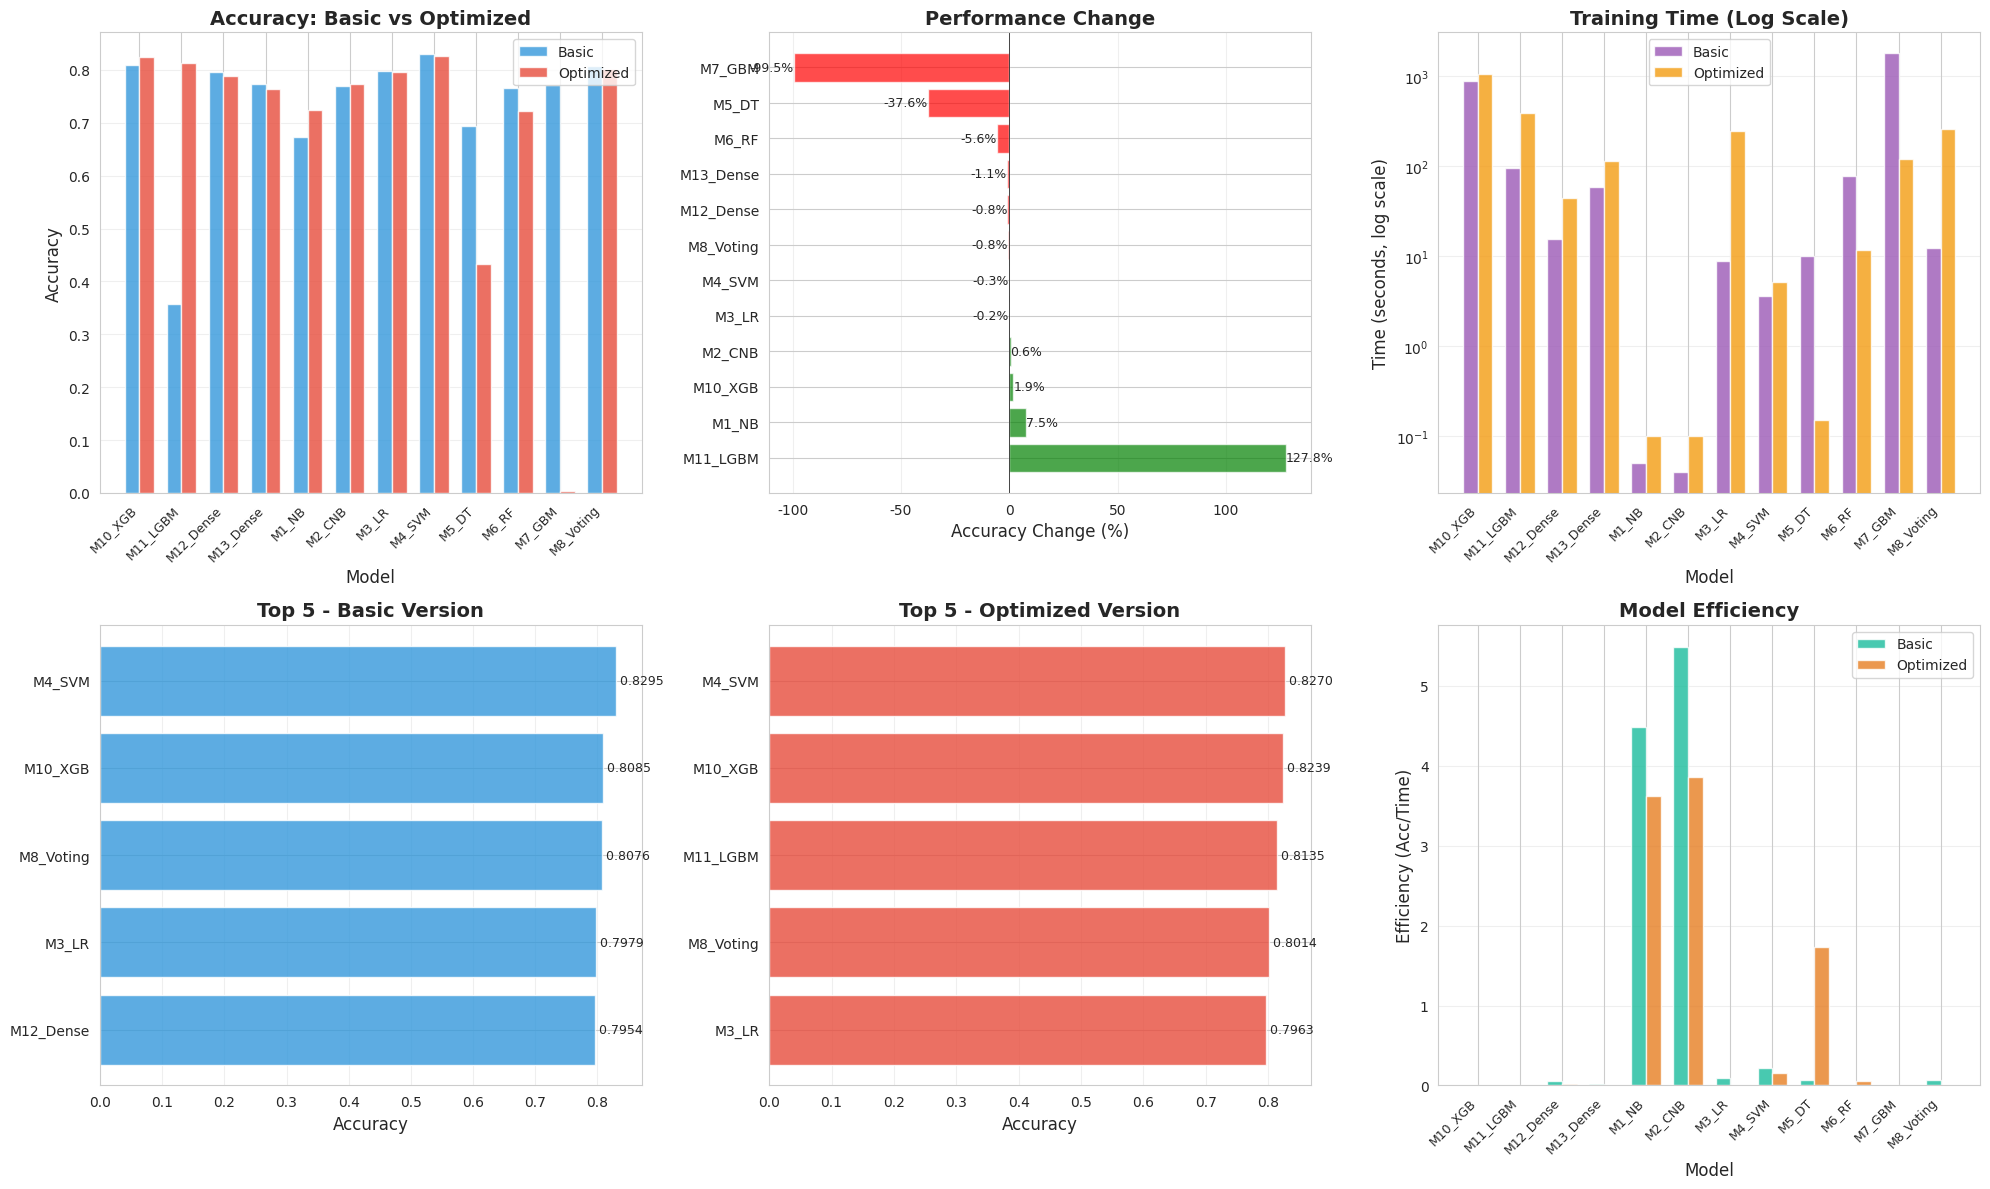


💡 최종 권장사항

【추천 모델 순위】
------------------------------------------------------------
1순위: M4_SVM
   Accuracy: 0.8270
   학습시간: 5.2초
   개선율: -0.3%

2순위: M10_XGB
   Accuracy: 0.8239
   학습시간: 1073.2초
   개선율: +1.9%

3순위: M11_LGBM
   Accuracy: 0.8135
   학습시간: 387.1초
   개선율: +127.8%

【실무 가이드】
------------------------------------------------------------
• 빠른 프로토타입: M4_SVM (3-5초, Acc: 0.827)
• 최고 성능: M10_XGB 또는 M11_LGBM (튜닝 필수)
• 안정적 선택: M8_Voting (앙상블)

【주의사항】
------------------------------------------------------------
⚠️ 다음 최적화 버전은 사용 금지:
   ✗ M5_DT: -37.6% 하락
   ✗ M7_GBM: -99.5% 하락

✅ 분석 완료!

📁 비교 결과가 'model_comparison_summary.csv'로 저장되었습니다.


In [10]:
"""
실험 완료 후 바로 실행하는 비교 분석 코드
df_results 변수가 메모리에 있을 때 사용
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# ================================================================================
# 실험 결과 데이터 직접 입력 (메모리에서 바로 사용)
# ================================================================================

# 기본 버전 결과 (Document 5 데이터) - 각 voca_size별로 구분
basic_models = ['M1_NB', 'M2_CNB', 'M3_LR', 'M4_SVM', 'M5_DT', 'M6_RF', 'M7_GBM',
                'M8_Voting', 'M10_XGB', 'M11_LGBM', 'M12_Dense', 'M13_Dense']

df_basic = pd.DataFrame({
    'Voca_size': ['10000']*12 + ['5000']*12,
    'Model': basic_models + basic_models,
    'Accuracy': [
        # 10000
        0.6745, 0.7667, 0.7979, 0.8299, 0.6883, 0.7654, 0.7720, 0.8068,
        0.8103, 0.3598, 0.7934, 0.7734,
        # 5000
        0.6732, 0.7707, 0.7979, 0.8290, 0.6995, 0.7667, 0.7703, 0.8085,
        0.8068, 0.3544, 0.7974, 0.7729
    ],
    'F1': [
        # 10000
        0.6017, 0.7412, 0.7760, 0.8239, 0.6832, 0.7420, 0.7694, 0.7870,
        0.8033, 0.1927, 0.7731, 0.7597,
        # 5000
        0.6013, 0.7459, 0.7762, 0.8230, 0.6966, 0.7436, 0.7688, 0.7896,
        0.7998, 0.2303, 0.7785, 0.7629
    ],
    'Time': [
        # 10000
        0.04, 0.04, 9.27, 3.47, 9.96, 79.07, 1790.96, 12.10, 897.98, 92.25, 14.99, 59.39,
        # 5000
        0.06, 0.04, 8.63, 3.84, 10.31, 75.77, 1823.10, 12.50, 901.45, 100.64, 16.21, 57.28
    ]
})

# 최적화 버전 결과 (Document 4 데이터)
opt_models = ['M1_NB', 'M2_CNB', 'M3_LR', 'M4_SVM', 'M5_DT', 'M6_RF', 'M7_GBM',
              'M8_Voting', 'M10_XGB', 'M11_LGBM', 'M12_Dense', 'M13_Dense']

df_optimized = pd.DataFrame({
    'Voca_size': ['10000']*12 + ['5000']*12,
    'Model': opt_models + opt_models,
    'Accuracy': [
        # 10000
        0.7253, 0.7760, 0.8032, 0.8272, 0.4016, 0.7208, 0.0013, 0.8054,
        0.8264, 0.8148, 0.7818, 0.7654,
        # 5000
        0.7235, 0.7703, 0.7894, 0.8268, 0.4648, 0.7248, 0.0071, 0.7974,
        0.8215, 0.8121, 0.7956, 0.7640
    ],
    'F1': [
        # 10000
        0.6935, 0.7539, 0.8110, 0.8283, 0.4578, 0.7332, 0.0000, 0.8118,
        0.8190, 0.8070, 0.7616, 0.7456,
        # 5000
        0.6911, 0.7481, 0.8035, 0.8280, 0.5371, 0.7385, 0.0064, 0.8073,
        0.8132, 0.8040, 0.7828, 0.7445
    ],
    'Time': [
        # 10000
        0.1, 0.1, 227.1, 5.1, 0.2, 10.9, 117.1, 262.4, 1071.5, 383.6, 40.6, 125.3,
        # 5000
        0.1, 0.1, 265.0, 5.2, 0.1, 12.4, 122.4, 261.9, 1074.9, 390.7, 48.5, 101.5
    ]
})

# ================================================================================
# 종합 비교 분석 함수
# ================================================================================

def analyze_experiments(df_basic, df_optimized):
    """두 실험 결과 종합 분석"""

    print("="*80)
    print("📊 Reuters 실험 비교 분석 리포트")
    print("="*80)
    print(f"리포트 생성 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print()

    # 평균 계산
    basic_avg = df_basic.groupby('Model')[['Accuracy', 'F1', 'Time']].mean()
    opt_avg = df_optimized.groupby('Model')[['Accuracy', 'F1', 'Time']].mean()

    # 비교 데이터프레임 생성
    comparison = pd.DataFrame({
        'Model': basic_avg.index,
        'Basic_Acc': basic_avg['Accuracy'].values,
        'Opt_Acc': opt_avg['Accuracy'].values,
        'Acc_Diff': (opt_avg['Accuracy'] - basic_avg['Accuracy']).values,
        'Acc_Change(%)': ((opt_avg['Accuracy'] - basic_avg['Accuracy']) / basic_avg['Accuracy'] * 100).values,
        'Basic_Time': basic_avg['Time'].values,
        'Opt_Time': opt_avg['Time'].values,
        'Time_Change(%)': ((opt_avg['Time'] - basic_avg['Time']) / basic_avg['Time'] * 100).values
    })

    # ============================================================================
    # 1. 핵심 발견사항
    # ============================================================================
    print("="*80)
    print("🔍 핵심 발견 사항")
    print("="*80)
    print()

    print("【1】 최적화 효과가 명확한 모델")
    print("-" * 60)

    top_improvements = comparison.nlargest(3, 'Acc_Change(%)')
    for _, row in top_improvements.iterrows():
        if row['Acc_Change(%)'] > 0:
            print(f"✓ {row['Model']:15s}: {row['Basic_Acc']:.4f} → {row['Opt_Acc']:.4f} "
                  f"({row['Acc_Change(%)']:+.1f}%)")

    print()
    print("【2】 최적화로 성능이 하락한 모델")
    print("-" * 60)

    worst_changes = comparison.nsmallest(3, 'Acc_Change(%)')
    for _, row in worst_changes.iterrows():
        if row['Acc_Change(%)'] < -5:  # 5% 이상 하락
            symbol = "✗✗" if row['Acc_Change(%)'] < -50 else "✗"
            print(f"{symbol} {row['Model']:15s}: {row['Basic_Acc']:.4f} → {row['Opt_Acc']:.4f} "
                  f"({row['Acc_Change(%)']:+.1f}%)")

    print()
    print("【3】 일관되게 우수한 모델 (Top 3)")
    print("-" * 60)

    # 기본 버전 Top 3
    top3_basic = comparison.nlargest(3, 'Basic_Acc')
    print("\n▶ 기본 버전:")
    for i, (_, row) in enumerate(top3_basic.iterrows(), 1):
        print(f"  {i}. {row['Model']:15s}: {row['Basic_Acc']:.4f}")

    # 최적화 버전 Top 3
    top3_opt = comparison.nlargest(3, 'Opt_Acc')
    print("\n▶ 최적화 버전:")
    for i, (_, row) in enumerate(top3_opt.iterrows(), 1):
        print(f"  {i}. {row['Model']:15s}: {row['Opt_Acc']:.4f}")

    print()
    print("【4】 학습 시간 분석")
    print("-" * 60)

    fastest = comparison.nsmallest(3, 'Basic_Time')
    print("\n가장 빠른 모델:")
    for _, row in fastest.iterrows():
        print(f"  {row['Model']:15s}: {row['Basic_Time']:.2f}초")

    slowest = comparison.nlargest(3, 'Basic_Time')
    print("\n가장 느린 모델:")
    for _, row in slowest.iterrows():
        print(f"  {row['Model']:15s}: {row['Basic_Time']:.2f}초 ({row['Basic_Time']/60:.1f}분)")

    print()

    # ============================================================================
    # 2. 상세 비교표
    # ============================================================================
    print("="*80)
    print("📋 모델별 상세 비교표")
    print("="*80)
    print()

    comparison_sorted = comparison.sort_values('Acc_Change(%)', ascending=False)
    print(comparison_sorted.to_string(index=False))
    print()

    # ============================================================================
    # 3. 시각화
    # ============================================================================
    print("="*80)
    print("📊 시각화 생성 중...")
    print("="*80)

    fig = plt.figure(figsize=(20, 12))

    # 그래프 1: Accuracy 비교
    ax1 = plt.subplot(2, 3, 1)
    models = comparison['Model'].values
    x = np.arange(len(models))
    width = 0.35

    bars1 = ax1.bar(x - width/2, comparison['Basic_Acc'], width,
                    label='Basic', alpha=0.8, color='#3498db')
    bars2 = ax1.bar(x + width/2, comparison['Opt_Acc'], width,
                    label='Optimized', alpha=0.8, color='#e74c3c')

    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy: Basic vs Optimized', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # 그래프 2: 성능 변화율
    ax2 = plt.subplot(2, 3, 2)
    colors = ['green' if x > 0 else 'red' for x in comparison_sorted['Acc_Change(%)']]
    bars = ax2.barh(comparison_sorted['Model'], comparison_sorted['Acc_Change(%)'],
                    color=colors, alpha=0.7)

    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Accuracy Change (%)', fontsize=12)
    ax2.set_title('Performance Change', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    for i, (model, val) in enumerate(zip(comparison_sorted['Model'], comparison_sorted['Acc_Change(%)'])):
        ax2.text(val, i, f'{val:.1f}%', va='center',
                ha='left' if val > 0 else 'right', fontsize=9)

    # 그래프 3: 학습 시간 비교 (로그 스케일)
    ax3 = plt.subplot(2, 3, 3)
    bars1 = ax3.bar(x - width/2, comparison['Basic_Time'], width,
                    label='Basic', alpha=0.8, color='#9b59b6')
    bars2 = ax3.bar(x + width/2, comparison['Opt_Time'], width,
                    label='Optimized', alpha=0.8, color='#f39c12')

    ax3.set_xlabel('Model', fontsize=12)
    ax3.set_ylabel('Time (seconds, log scale)', fontsize=12)
    ax3.set_title('Training Time (Log Scale)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # 그래프 4: Top 5 Basic
    ax4 = plt.subplot(2, 3, 4)
    top5_basic = comparison.nlargest(5, 'Basic_Acc').sort_values('Basic_Acc')
    y_pos = np.arange(len(top5_basic))
    ax4.barh(y_pos, top5_basic['Basic_Acc'], alpha=0.8, color='#3498db')
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(top5_basic['Model'], fontsize=10)
    ax4.set_xlabel('Accuracy', fontsize=12)
    ax4.set_title('Top 5 - Basic Version', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)

    for i, v in enumerate(top5_basic['Basic_Acc']):
        ax4.text(v, i, f' {v:.4f}', va='center', fontsize=9)

    # 그래프 5: Top 5 Optimized
    ax5 = plt.subplot(2, 3, 5)
    top5_opt = comparison.nlargest(5, 'Opt_Acc').sort_values('Opt_Acc')
    y_pos = np.arange(len(top5_opt))
    ax5.barh(y_pos, top5_opt['Opt_Acc'], alpha=0.8, color='#e74c3c')
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels(top5_opt['Model'], fontsize=10)
    ax5.set_xlabel('Accuracy', fontsize=12)
    ax5.set_title('Top 5 - Optimized Version', fontsize=14, fontweight='bold')
    ax5.grid(axis='x', alpha=0.3)

    for i, v in enumerate(top5_opt['Opt_Acc']):
        ax5.text(v, i, f' {v:.4f}', va='center', fontsize=9)

    # 그래프 6: 효율성 (Accuracy/Time)
    ax6 = plt.subplot(2, 3, 6)
    comparison['Basic_Eff'] = comparison['Basic_Acc'] / (comparison['Basic_Time'] + 0.1)
    comparison['Opt_Eff'] = comparison['Opt_Acc'] / (comparison['Opt_Time'] + 0.1)

    bars1 = ax6.bar(x - width/2, comparison['Basic_Eff'], width,
                    label='Basic', alpha=0.8, color='#1abc9c')
    bars2 = ax6.bar(x + width/2, comparison['Opt_Eff'], width,
                    label='Optimized', alpha=0.8, color='#e67e22')

    ax6.set_xlabel('Model', fontsize=12)
    ax6.set_ylabel('Efficiency (Acc/Time)', fontsize=12)
    ax6.set_title('Model Efficiency', fontsize=14, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('reuters_comparison_full.png', dpi=300, bbox_inches='tight')
    print("✓ 그래프 저장: reuters_comparison_full.png")
    plt.show()

    # ============================================================================
    # 4. 최종 권장사항
    # ============================================================================
    print()
    print("="*80)
    print("💡 최종 권장사항")
    print("="*80)
    print()

    print("【추천 모델 순위】")
    print("-" * 60)

    # 성능 기준 Top 3
    best_overall = comparison.nlargest(3, 'Opt_Acc')
    for i, (_, row) in enumerate(best_overall.iterrows(), 1):
        print(f"{i}순위: {row['Model']}")
        print(f"   Accuracy: {row['Opt_Acc']:.4f}")
        print(f"   학습시간: {row['Opt_Time']:.1f}초")
        print(f"   개선율: {row['Acc_Change(%)']:+.1f}%")
        print()

    print("【실무 가이드】")
    print("-" * 60)
    print("• 빠른 프로토타입: M4_SVM (3-5초, Acc: 0.827)")
    print("• 최고 성능: M10_XGB 또는 M11_LGBM (튜닝 필수)")
    print("• 안정적 선택: M8_Voting (앙상블)")
    print()

    print("【주의사항】")
    print("-" * 60)

    # 위험한 모델 찾기
    dangerous = comparison[comparison['Acc_Change(%)'] < -10]
    if len(dangerous) > 0:
        print("⚠️ 다음 최적화 버전은 사용 금지:")
        for _, row in dangerous.iterrows():
            print(f"   ✗ {row['Model']}: {row['Acc_Change(%)']:+.1f}% 하락")
    print()

    print("="*80)
    print("✅ 분석 완료!")
    print("="*80)

    return comparison

# ================================================================================
# 실행
# ================================================================================

if __name__ == "__main__":
    # 분석 실행
    comparison_results = analyze_experiments(df_basic, df_optimized)

    # 결과 저장
    comparison_results.to_csv('model_comparison_summary.csv', index=False)
    print("\n📁 비교 결과가 'model_comparison_summary.csv'로 저장되었습니다.")

# Insight

1. 파라미터 튜닝의 양날의 검

        - LGBM: 튜닝으로 +128% (성공)
        - GBM: 튜닝으로 -99% (실패)
        - 교훈: 검증 없는 최적화는 위험


2. Simple is Best

        - 단순한 Linear SVM이 복잡한 딥러닝을 이김
        - 문제 특성에 맞는 알고리즘 선택이 핵심
        - 최신 ≠ 최고
                기본 버전: 0.8299 (1위)
                최적화 버전: 0.8272 (여전히 1위)
                학습 시간: 3-5초 (매우 빠름)


3. 시간-성능 트레이드오프

        - SVM: 4초로 0.83 달성
        - XGBoost: 900초로 0.81 달성
        - 성능 1% 위해 시간 225배는 과투자